In [55]:
%load_ext autoreload
%autoreload 2

import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, transform, color
from colorize import network, util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
net = network.Net()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 112, 112]          36,928
       BatchNorm2d-3         [-1, 64, 112, 112]             128
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5          [-1, 128, 56, 56]         147,584
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 28, 28]         590,080
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-14          [-1, 512,

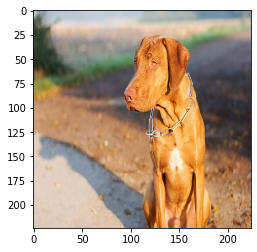

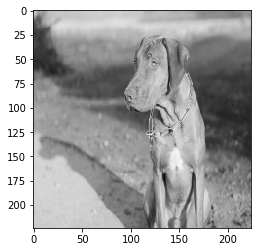

In [78]:
images = glob.glob("data/**/*.jpg")
for image in images:
    img = io.imread(image)
    img = transform.resize(img, (224, 224))
    plt.imshow(img)
    plt.show()
    
    lab = color.rgb2lab(img)
    L = lab[:,:,0][np.newaxis,np.newaxis,...]
    x = torch.tensor(L, dtype=torch.float32)
    ab = net.forward(x).data.numpy()
    ab = ndi.zoom(ab, [1,1,4,4])
    Lab = np.concatenate((L, ab), axis=1).transpose(2, 3, 1, 0).reshape(lab.shape)
    rgb = color.lab2rgb(Lab)
    plt.imshow(rgb)
    plt.show()
    break

In [4]:
Y = np.random.normal(size=(5,4,2))
Z = util.soft_encoding(Y, debug=True)

Z.shape: (5, 4, 313)
